## ResNet
- 一个网络如果越来越复杂并且不包含原来的块，那么复杂网络学习到的参数可能还没有之前简单的网络学习到的参数好一些
- 所以设计一个网络来使得复杂的网络包含原来简单的网络，最起码训练出来的网络不会变差

<img src='../images/29image1.png' width='500'>

- 残差连接的实现有两种方法
  - 一种是没有改变通道数，直接相加就可以
  - 一种是改变了通道数，需要在旁路加一个1 X 1的卷积进行通道数转换

<img src='../images/29image2.png' width='500'>

In [13]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y = Y + X
        return F.relu(Y)

In [14]:
X = torch.randn(4, 3, 6, 6)
blk = Residual(3, 3)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [15]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
Y = blk(X)
Y.shape

torch.Size([4, 6, 3, 3])

In [16]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, padding=3, stride=2), 
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2)
)

In [17]:
def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(in_channels, out_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(out_channels, out_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

loss 0.024, train acc 0.991, test acc 0.926
1887.7 examples/sec on cuda:0


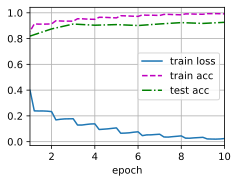

In [18]:
net = nn.Sequential(b1, b2, b3, b4, b5, 
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

lr, num_epochs, batch_size = 0.05, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, 96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())